In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F

import torch
import os

import numpy as np


from torch.utils.data import DataLoader
from tqdm import tqdm

import cv2

import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from prettytable import PrettyTable

import optuna

In [2]:
column_name = 'recognized_text_easyocr'

In [3]:
def get_features(model, dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, texts, labels, path in tqdm(DataLoader(dataset, batch_size=100)):
            
            image_input = torch.tensor(np.stack(images)).cuda()
            text_tokens = clip.tokenize([desc[:50] for desc in texts]).cuda()
            
            image_features = model.encode_image(image_input).type(torch.float).cpu()
            text_features = model.encode_text(text_tokens).type(torch.float).cpu()

            features = torch.cat([image_features, text_features], dim=1)
            
            all_features.extend(features)
            all_labels.extend(labels)

    return all_features, all_labels


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    best_model_name = None
    loss_history = []
    train_history = []
    val_history = []
    top_val_accuracy = 0.52 
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x=x.type(torch.float).cpu()
            y = y.type(torch.float).cpu()
            model = model.cpu()
            prediction = model(x)    
            loss_value = loss(prediction, y.type(torch.long))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))

  
        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            model_name = f'classifier_{epoch}_{round(val_accuracy, 3)}.ckpt'
            best_model_name = model_name
            torch.save(model, open(model_name, 'wb'))
            print("saved", model_name)

    return loss_history, train_history, val_history, best_model_name
        
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0 
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
         
    return val_accuracy

In [4]:
prettyTable = PrettyTable(['Model name', 'Accuracy', 'ROC AUC'])

In [5]:
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize
from classes.dataset.FeaturesDataset import FeaturesDataset

In [6]:
CROP_SIZE=224

In [7]:
chars = set(' ')

for i in range(1040, 1104):
    #print(i, chr(i))
    chars.add(chr(i))
    
for i in range(48, 58):
    #print(i, chr(i))
    chars.add(chr(i))    
    
#chars

In [8]:
def clear(s):
    return sum([1 if c in chars else 0 for c in s]) / (len(s) + 1e-6)

In [9]:
import torch
import json
import os
from PIL import Image
import cv2
from cv2 import cv2


class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms, column_name):
        self.data = [json.loads(l) for l in open(data_path)]
        
        self.data = [x for x in self.data if x['label'] != 3]
        self.data = [x for x in self.data if clear(x[column_name]) > 0.05]
        for x in self.data:
            if x['label'] != 0:
                x['label'] = 1
                
        self.data_dir = os.path.dirname(data_path)
        self.transforms = transforms
        self.column_name = column_name
        
    def __getitem__(self, index: int):
        #image = Image.open(os.path.join(self.data_dir, self.data[index]["img"]))   
        
        path = os.path.join(self.data_dir, self.data[index]["img"])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        text = self.data[index][self.column_name]
        label = self.data[index]["label"]

        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, text, label, path
    
    def __len__(self):
        return len(self.data)

In [10]:
data_dir = r'C:\Users\notebook\Downloads\_my_dataset\20221214_hateful_memes\hateful_memes\\'

In [11]:
train_path = data_dir + 'train_trans.jsonl'
dev_path = data_dir + 'test_trans.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [12]:
train_data

,label,img,recognized_text_easyocr,translated_text
0,3,img/10910387.jpg,Бг]~яЁЦШ ВваЗКЕ;а ~БецЕаноляЕБа #д ГеияТЪ_Цы ш...,Бг] ~ яЁЦШ ВваЗКЕ; а ~ БецЕноляЕБа # д ГеияТЬ ...
1,3,img/10747369.jpg,[ы КУбШШЬ? ТШЛЬКШ КЛЁДАМУЕЮ: # -Ш,[s КУБШШШЬ? ТШЛЬKS КЛЁДАМУВЕЯ: # -Ш
2,0,img/13996726.jpg,ОКАЗАЛОСЬ МОЯ СЕСТРА ПО НОЧАМ ЗАНИМАЕТСЯ ПРОСТ...,MY SISTER IS BELIEVED BY PROSTITUTION AT NIGHT...
3,1,img/9987066.jpg,,"In fact, there is no such thing as a free lunch."
4,0,img/16702250.jpg,ВЕМШДШЧЮИ ЩЛ ЛАЙК ПШВТПВШЮ Е#я,ВЕМШДШЧУИ ШЛЫК ЛАЙК ПШВВВШВШЕ Е # я
...,...,...,...,...
626,3,img/14293988.jpg,МШТЯП Ктьйе ПОДШЕ ПДИШЛМ,KATIE HOPKINS
627,3,img/13082683.jpg,"СКОЛЬКО ВЕСИТ ИДЕАЛЬНЫЙ ЕВРЕЙ? 0,2 КИЛОГРАММА ...",How much does an IDEAL EURY weigh? 0.2 CILOGRA...
628,0,img/15659398.jpg,,"In fact, there is no such thing as a free lunch."
629,0,img/12081951.jpg,"~""Яе эяю @елъ_у_~__ [ @едеек Ы₽","~ ""Ye ejaculate @ el _ y _ _ _ _ [@ edshew]"""


In [13]:
test_data

,label,img,recognized_text_easyocr,translated_text
0,0,img/13037928.jpg,"сЕе- ИУшЕЕ ИЕКАРСТЕО ПАП НУ Я УЖЕ, ЕЫзДОРОВИЙ ...","CY-JESE JEKARSTEO PAP I AM NO YEARS, NO YEARS:..."
1,6,img/9664522.jpg,ПЛКЕНше #+ ааыТь МЯГИ пипа: щп8 ФыФщСЙ,PLKENSHE # + ааыТь МяГИ пипа: щп8 ФыФщСY
2,1,img/15448302.jpg,Она: рсе; мне болыше не нужны мужики] € эгого ...,She: rse; I don't need men anymore] I'm a prou...
3,0,img/16702294.jpg,Измени свою жилнь (РИстИанствовё хорошо хоть в...,Change your dwelling (RISTYANSTEVO is good eve...
4,0,img/15244154.jpg,Невидимый кЕ@е[ и Хэнк Всадннки ЯП Апокалипснс...,The Invisible KE @ e [and Hank Horseshoe of JP...
...,...,...,...,...
206,1,img/12954537.jpg,"""25 :""5й@4?й; #""; 4; ЕЕМ4И '415д - ""44 < ЁЖ5{4...","""25:"" 5th @ 4? y; # ""; 4; ЕЕМ4И '415d -"" 44 < ..."
207,6,img/16180208.jpg,,"In fact, there is no such thing as a free lunch."
208,0,img/15244043.jpg,"Да чТа { @Жет бть кужсе, чем несколько детей М...",Yes read {@ Jet bt kuzse than a few children b...
209,0,img/14993032.jpg,КГДАЛРИ ЧИСКЕ МАНДАРШНМ #ЕЧЫВСАВЧЕШЬ ЗИПАХА ЮВ...,KGDALRI CHISKE MANDARSHIP # CHISKE ZIPAHA YUSH...


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### CLIP zero-shot learning

In [16]:
#https://github.com/openai/CLIP
model, preprocess = clip.load("ViT-L/14", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.946    0.04822  0.005985]]


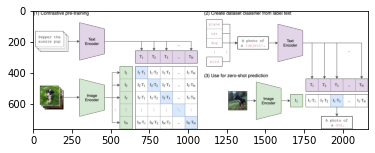

In [17]:
plt.imshow(Image.open("CLIP.png"))

In [18]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001E269AB6700>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

#### Предобработка изображений

In [19]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [20]:
transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])


In [21]:
train_dataset = HatefulMemesDataset(train_path, transforms, column_name)
val_dataset = HatefulMemesDataset(dev_path, transforms, column_name)
len(train_dataset), len(val_dataset)

(364, 149)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]


('ОКАЗАЛОСЬ МОЯ СЕСТРА ПО НОЧАМ ЗАНИМАЕТСЯ ПРОСТИТУЦИЕЙ; ПОЭТОМУ ПРЕДЫДУЩИЕ ДВЕ НЕДЕЛИ Я КАЖДЫЙ ДЕНЬ ЗАБИРАЛ ЕЕ С УЛИЦЫ ОБЫЧНО НА ЧАС ИЛИ ОКОЛО ТОГО', 'ВЕМШДШЧЮИ ЩЛ ЛАЙК ПШВТПВШЮ Е#я', 'КОГДА ВИДИШЬ СВОЮ БЫВШУЮ НОВЫМ ПАРНЕМ АТЫ ПОМНИШЬ ВСЕ МОМЕНТЫ КАК ОНА ЛИЗАЛА ТВОЮ ЖОПУ Я ЗНАЮ ТО, ЧЕГО НЕ ЗНАЕШЬ ТЫ', 'МОН @РЭУШШНиДеЯМ4459В: ШеадиБШНОпдеШШы ОШЛ#ВИзОН; ЧшЛЫВЫОРННДПеЙМНЛМОВИОПЦЛИВаШ ВУнШЖИ НеШЧПНШЛЮНйефЬ', 'ВЫ тожжЕ Иж ВИДИТЕ?', 'в сеть слиты кадры секретный саж1олёт армении', 'ОРЕЛРИТошыБы Шлв иЛявнарЕ ЕвЗ ХЛЁБХ = 1г', 'Юривот помоги а фш убрянх Лишнюю шнягу Заранон опасибв {оювош')


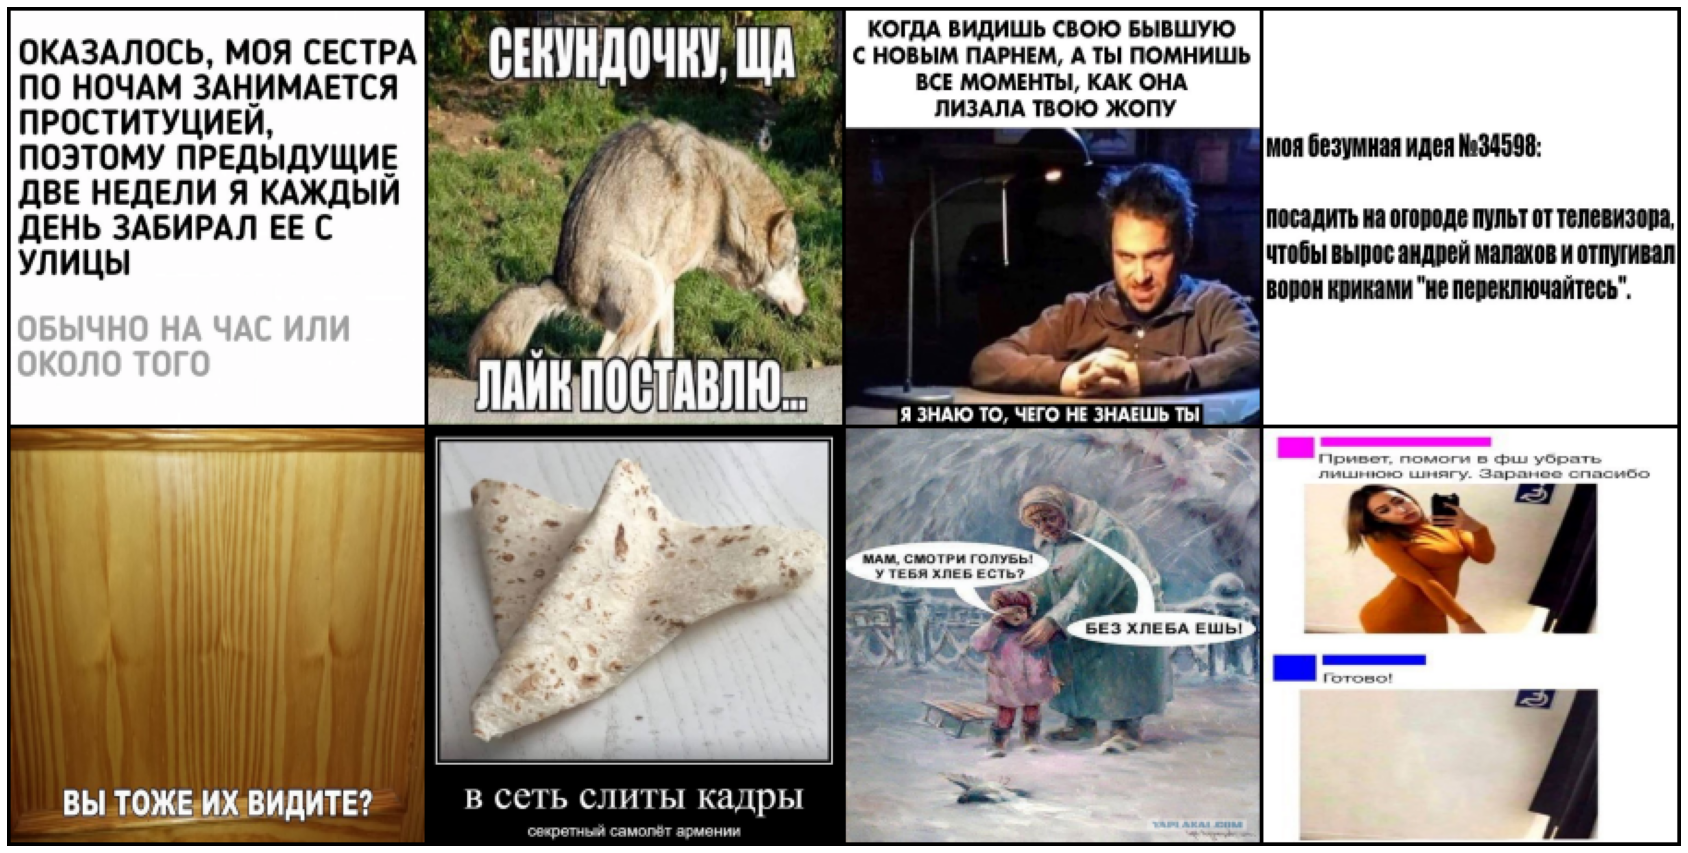

In [22]:
for images, texts, labels, path in tqdm(DataLoader(train_dataset, batch_size=8)):
    #print(images[0].shape, texts[0], labels[0] , labels.shape)
    break
    
grid = torchvision.utils.make_grid([(x * STD[:, None, None] + MEAN[:, None, None]) for x in images], nrow = 4)#
plt.figure(figsize=(30,20)); 
plt.axis(False)
plt.imshow(F.to_pil_image(grid));

print(texts)

#### Извлекаем признаки из текста и картинок

In [23]:
features_train, labels_train = get_features(model, train_dataset)
features_val, labels_val = get_features(model, val_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


In [24]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

#### Обучение нейросети

In [25]:
input_shape = features_train_dataset[0][0].shape[0]
num_classes = 2

In [26]:
input_shape

1536

In [27]:
torch.manual_seed(1024)

shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 200, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=1536, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.739850, Train accuracy: 0.467033, Val accuracy: 0.630872
saved classifier_0_0.631.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.822269, Train accuracy: 0.557692, Val accuracy: 0.369128
Epoch: 2 lr: 0.010000; Average loss: 0.742249, Train accuracy: 0.519231, Val accuracy: 0.369128
Epoch: 3 lr: 0.010000; Average loss: 0.699945, Train accuracy: 0.543956, Val accuracy: 0.436242
Epoch: 4 lr: 0.010000; Average loss: 0.681341, Train accuracy: 0.585165, Val accuracy: 0.

Epoch: 86 lr: 0.001678; Average loss: 0.018947, Train accuracy: 0.997253, Val accuracy: 0.489933
Epoch: 87 lr: 0.001678; Average loss: 0.019021, Train accuracy: 0.997253, Val accuracy: 0.489933
Epoch: 88 lr: 0.001678; Average loss: 0.009819, Train accuracy: 1.000000, Val accuracy: 0.483221
Epoch: 89 lr: 0.001342; Average loss: 0.008841, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 90 lr: 0.001342; Average loss: 0.014638, Train accuracy: 0.994505, Val accuracy: 0.489933
Epoch: 91 lr: 0.001342; Average loss: 0.011312, Train accuracy: 0.997253, Val accuracy: 0.489933
Epoch: 92 lr: 0.001342; Average loss: 0.011285, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 93 lr: 0.001342; Average loss: 0.017880, Train accuracy: 0.997253, Val accuracy: 0.496644
Epoch: 94 lr: 0.001342; Average loss: 0.012661, Train accuracy: 1.000000, Val accuracy: 0.503356
Epoch: 95 lr: 0.001342; Average loss: 0.011091, Train accuracy: 1.000000, Val accuracy: 0.503356
Epoch: 96 lr: 0.001342; Averag

Epoch: 177 lr: 0.000225; Average loss: 0.004590, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 178 lr: 0.000225; Average loss: 0.005146, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 179 lr: 0.000180; Average loss: 0.007365, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 180 lr: 0.000180; Average loss: 0.005010, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 181 lr: 0.000180; Average loss: 0.004419, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 182 lr: 0.000180; Average loss: 0.006141, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 183 lr: 0.000180; Average loss: 0.010267, Train accuracy: 0.997253, Val accuracy: 0.489933
Epoch: 184 lr: 0.000180; Average loss: 0.009289, Train accuracy: 1.000000, Val accuracy: 0.489933
Epoch: 185 lr: 0.000180; Average loss: 0.010418, Train accuracy: 0.994505, Val accuracy: 0.496644
Epoch: 186 lr: 0.000180; Average loss: 0.006310, Train accuracy: 1.000000, Val accuracy: 0.496644
Epoch: 187 lr: 0.000

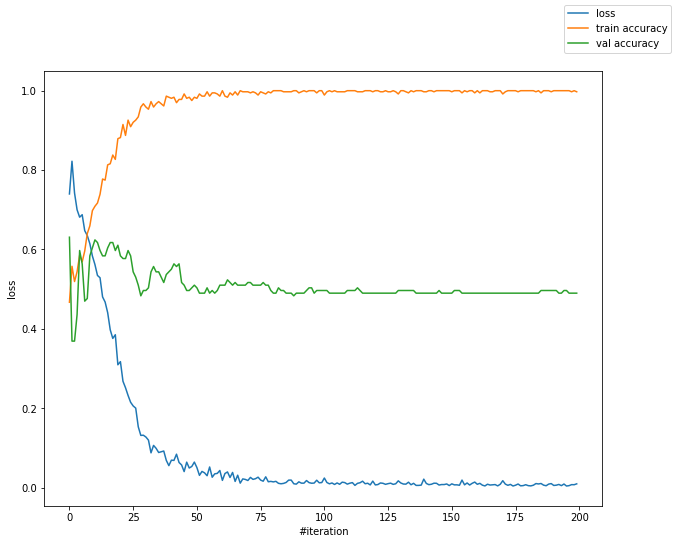

In [28]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [29]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

best model: classifier_0_0.631.ckpt
Sequential(
  (0): Linear(in_features=1536, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


Accuracy: 0.6308724832214765
ROC AUC: 0.5485493230174081


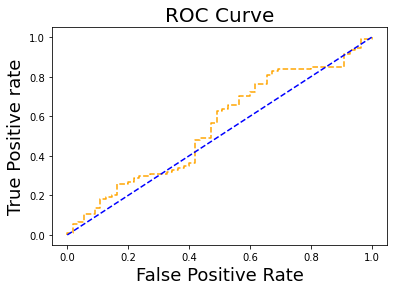

In [30]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
prettyTable.add_row(['Neural Network', acc_score, auc_score])

fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())

print('Accuracy: ', acc_score, '\n', 'ROC AUC: ', auc_score, sep='')

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

In [31]:
print(prettyTable)

+----------------+--------------------+--------------------+
|   Model name   |      Accuracy      |      ROC AUC       |
+----------------+--------------------+--------------------+
| Neural Network | 0.6308724832214765 | 0.5485493230174081 |
+----------------+--------------------+--------------------+


In [32]:
#0.9  0.6132075471698113 | 0.4574108818011257
#0.7  0.6538461538461539 | 0.6158536585365854
#0.5  0.6338028169014085 | 0.601010101010101
#0.3  0.6232876712328768 | 0.5652347652347653
#0.05  0.6308724832214765 | 0.5485493230174081